In [15]:
import os
import requests
import datetime
import itertools
import geojsonio
# import geopandas as gpd
import matplotlib.pyplot as plt
from descartes import PolygonPatch

## Inputs

In [16]:
# your AgroDataCube access token - replace this code or add the OS environment variable
token = os.environ["AGRODATACUBE_TOKEN"]

In [17]:
year = 2016           # valid range: 2013 - 2017, note that the 2013-2015 data seems to be incorrect!
crop_code = 256       # 256 = sugarbeets, 262 = zaai-uien, 233 = wintertarwe, 234 = zomertarwe, 259 = snijmais
prov_name = "Limburg" # name of provence to find crop fields for (e.g. Fryslân, or Noord-Holland)

In [18]:
request_header = {"token":token}

## Retrieve the crop name for the specified crop code

In [19]:
cropcode_url = "http://agrodatacube.wur.nl/api/v1/rest/codes/cropcodes/{0}".format(crop_code)
cropcode_data = requests.get(cropcode_url, headers=request_header)
cropcode = cropcode_data.json()
len(cropcode["features"])

1

In [20]:
crop_name = cropcode["features"][0]["properties"]["cropname"]
print(crop_name)

Bieten, suiker-


## Calculate the bounding box of the selected province

In [21]:
# read info on all Dutch provinces of 2015
prov_url = "http://agrodatacube.wur.nl/api/v1/rest/regions/provences?page_size=25&output_epsg=28992&page_offset=0"
prov_data = requests.get(prov_url, headers=request_header)
prov = prov_data.json()

Zuid-Holland Utrecht Gelderland Flevoland Fryslân Limburg Zeeland Overijssel Noord-Brabant Noord-Holland Groningen Drenthe 

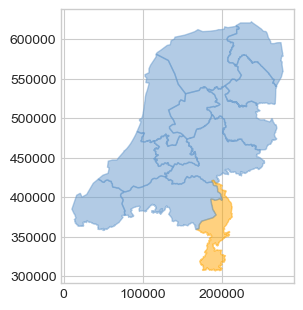

In [22]:
# plot all provinces as a map
BLUE = '#6699cc'
ORANGE = '#ffa500'
fig = plt.figure(figsize=(3,6), dpi=100)
ax = fig.gca()
for p in prov["features"]:
    print(p["properties"]["name"], end=' ')
    color = ORANGE if p["properties"]["name"] == prov_name else BLUE
    ax.add_patch(PolygonPatch(p["geometry"], fc=color, ec=color, alpha=0.5, zorder=2))
ax.axis('scaled')
plt.show()

In [23]:
# get the geometry of the selected province
area = [p for p in prov["features"] if p["properties"]["name"] == prov_name][0]["geometry"]["coordinates"][0]

In [24]:
# calculate bounding box of the province
x_min = 300000
x_max = 0
y_min = 700000
y_max = 300000

for polygon in area:
    for coordinate in polygon:
        if coordinate[0] < x_min:
            x_min = coordinate[0]
        if coordinate[0] > x_max:
            x_max = coordinate[0]
        if coordinate[1] < y_min:
            y_min = coordinate[1]
        if coordinate[1] > y_max:
            y_max = coordinate[1]
            
# create a wkt geometry for the bounding box
geom = "POLYGON(({0:.0f} {1:.0f}, {0:.0f} {3:.0f}, {2:.0f} {3:.0f}, {2:.0f} {1:.0f}, {0:.0f} {1:.0f}))".format(x_min, y_min, x_max, y_max)
print(geom)

POLYGON((167508 306839, 167508 421214, 213448 421214, 213448 306839, 167508 306839))


## Retrieve 1000 fields for the selected region, crop, and year

In [25]:
# read max 1000 fields for the specified year and within or intersecting the bounding box

fields_url = "http://agrodatacube.wur.nl/api/v1/rest/fields?epsg=28992&year={0}&geometry={1}&cropcode={2}&page_size=1000&page_offset=0".format(year, geom, crop_code)
fields_data = requests.get(fields_url, headers=request_header)
fields = fields_data.json()
print(fields_url)
print(fields_data.status_code)
# len(fields["features"])

http://agrodatacube.wur.nl/api/v1/rest/fields?epsg=28992&year=2016&geometry=POLYGON((167508 306839, 167508 421214, 213448 421214, 213448 306839, 167508 306839))&cropcode=256&page_size=1000&page_offset=0
200


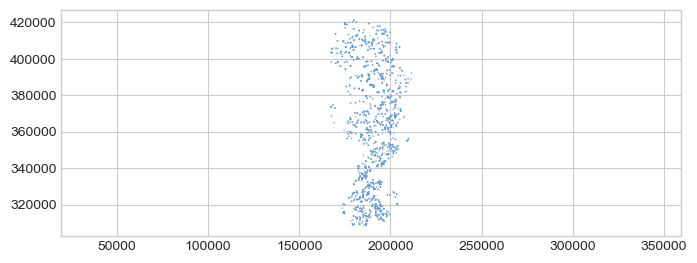

In [26]:
# plot all the fields on a map
BLUE = '#6699cc'
fig = plt.figure(figsize=(8,3), dpi=100)
ax = fig.gca()
for f in fields["features"]:
    ax.add_patch(PolygonPatch(f["geometry"], fc=BLUE, ec=BLUE, alpha=1.0, zorder=2))
ax.axis('equal')
plt.show()

## Retrieve the NDVI data for all the fields and plot a chart

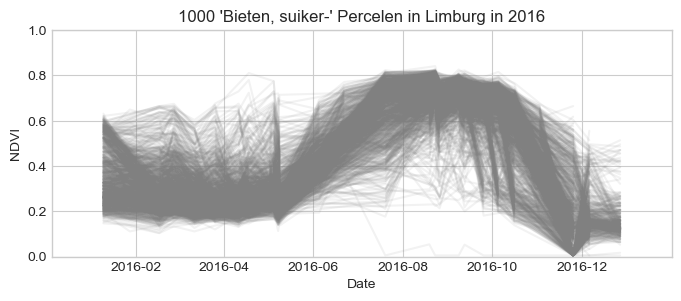

In [27]:
# plot ndvi data for all fields
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(8, 3), dpi=100)
ax = plt.axes()
ax.set_xmargin(0.1)
ax.set_alpha(0.5)
ax.autoscale(True)
ax.xaxis_date()

for field in fields["features"]:
    field_id = field["properties"]["fieldid"]
    ndvi_url = "http://agrodatacube.wur.nl/api/v1/rest/fields/{0}/ndvi?fromdate={1}&todate={2}&page_size=1000".format(field_id, year, year)
    ndvi_data = requests.get(ndvi_url, headers=request_header)
    ndvi_timeseries = ndvi_data.json()
    
    dates = [datetime.datetime.strptime(d["properties"]["datum"], '%Y-%m-%d').date() for d in ndvi_timeseries["features"]]
    values = [v["properties"]["ndvi_value"] for v in ndvi_timeseries["features"]]
    ax.plot(dates, values, color='grey', alpha=0.1)

ax.set(ylim=(0.0, 1.0), xlabel='Date', ylabel='NDVI', title="{0} '{1}' Percelen in {2} in {3}".format(len(fields["features"]), crop_name, prov_name, year));


In [28]:
# TODO plot weather per field for nearest weather station
# TODO the 1000 fields requested are in arbitrary order, might have an effect as well